In [1]:
%matplotlib notebook                      
import numpy as np                        # working with arrays
import imageio                            # reading images as an array
import matplotlib.pyplot as plt           # working with plots

from skimage.draw import ellipse 


In [2]:
import warnings

Xmin = -165             # reactor boundaries
Xmax = +165
Ymin = -165
Ymax = +165

Xsize = Xmax-Xmin       # size of the X_Y grid
Ysize = Ymax-Ymin    
dx  = 1               # space step in nm
dy  = dx                # dx = 8.5 nm

nX  = int(Xsize/dx)     # integer
nY  = int(Ysize/dy)

T  = 10000              # total time
dt = 1               # time step
nt = int(T/dt)          # number of iterations

f      = 0.073     # equilibrium konstant  
k_sol  = 0.1345      # solidification rate

I_cr = 7.5              # quenching parameters
h = 45

delta = 1.95
Ds1i = 0.112            # diffusion constants 
Ds2i = Ds1i/delta
Di   = 0.24

CFLx = Di*dt/(dx**2)    # CFL satbility criterion

mag_facf = 100
mf=mag_facf
Xm,XM,Ym,YM =(Xmin/dx)/mf,(Xmax/dx)/mf,(Ymax/dx)/mf,(Ymin/dx)/mf
ds0 = 1

if (CFLx > 0.24 ) : warnings.warn("\n  CFL* HAS BEEN REACHED: CFL={:.3f}".format(CFLx))

print('Grid size (rows):...................{}'.format(nY))
print('Estimated simulation time (min):....{:.2f}'.format((4.5e-4*nX+5.12e-3)**2.3*T/dt/60)) # empirical func.
print('CFL (CFL*=0.16):....................{:.3f}'.format(CFLx))

Grid size (rows):...................330
Estimated simulation time (min):....2.24
CFL (CFL*=0.16):....................0.240


In [16]:
def initial_raphe(w,L,k_max):
    x_run = np.linspace(0,L,L//dx)
    k_run = np.linspace(0,k_max,k_max/np.pi*L)

    y_run  = np.zeros((len(x_run)))
    for k in k_run:
        A1 = w/2*np.random.randn()
        A2 = w/2*np.random.randn()
        y_run =y_run + A1*np.cos(k*x_run) + A2*np.sin(k*x_run)
    y_run = np.round(y_run).astype(int)  


    U = np.ones((nY,nX))                  
    V = np.zeros((nY,nX))
    V[nY//2-1:nY//2+1,nX//2-L//2:nX//2+L//2]=0.4

    for j,i in enumerate(y_run,0):
        if i>=0:V[nY//2:nY//2+i+1,(nX//2-L//2)+j] =0.4
        if i<0:V[nY//2+i-1:nY//2,nX//2-L//2+j] =0.4
    #second raphe
    y_shift = 6 # pxls          
    V[nY//2-1+y_shift:nY//2+1+y_shift,nX//2-L//2:nX//2+L//2]=0.4

    for j,i in enumerate(y_run,0):
        if i>=0:V[nY//2+y_shift:nY//2+i+1+y_shift,(nX//2-L//2)+j] =0.4
        if i<0:V[nY//2+i-1+y_shift:nY//2+y_shift,nX//2-L//2+j] =0.4
    V[nY//2+1-1:nY//2-1+y_shift+1]=0
    
    ov=5
    V[nY//2+1-ov:nY//2-1+y_shift+ov,nX//2-6:nX//2+6] =0.4
    
    V[nY//2+1-1:nY//2-1+y_shift+1,nX//2-L//2] =0.4
    V[nY//2+1-1:nY//2-1+y_shift+1,nX//2+L//2] =0.4
    
    return(U,V)

<IPython.core.display.Javascript object>


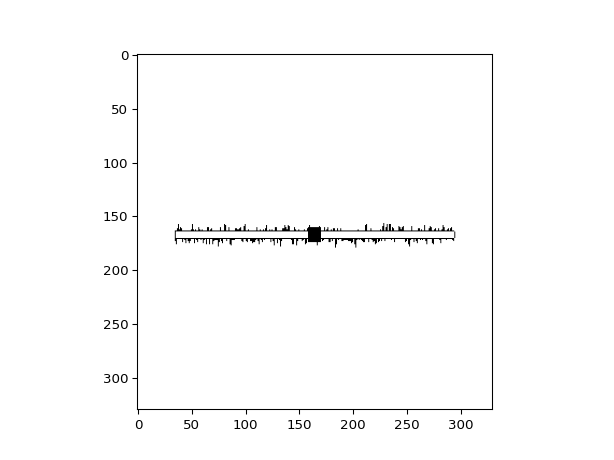

In [17]:
# visulaization of U-V IC:
U, V = initial_raphe(w=0.42,L=260,k_max=2.3) # relaxing state ,0.4,0.3

fig, ax = plt.subplots(dpi=120)
ax = plt.subplot(111)
ax.imshow(V,cmap='Greys')

In [12]:
import laplacians as LAP

# def quenching function 
def hill_func(C_cr,lam,c):
    h = C_cr**lam/(C_cr**lam+c**lam)
    return(h)

In [13]:
U, V = initial_raphe(w=0.42,L=260,k_max=2.3) # relaxing state ,0.42,26

In [14]:
h=45 #65
I_cr = 6#6.5

T = 2230                
n = int(T/dt)        

f      = 0.074       # equilibrium konstant  
k_sol  = 0.135       # solidification rate

Di   = 0.2
delta = 1.95 #1.95
Ds1i = 0.112         # diffusion constants 
Ds2i = Ds1i/delta

S1I, S2I = np.copy(U), np.copy(V) 

S3 = np.zeros(np.shape(U))
I  = np.zeros(np.shape(U)) 
uni = np.ones(np.shape(U))
sol = 1*np.ones(np.shape(U))

sigma = 1

for i in (range(n)):      
    
    deltaS1I = Ds1i*LAP.laplacian(S1I,dx=1)
    deltaS2I = Ds2i*LAP.laplacian(S2I,dx=1)
    deltaI   = Di*LAP.laplacian(I,dx=1)

    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    #delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    #sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)

    # Neumans b.c. 
    for Z in (S1I, S2I, S3, I):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

<IPython.core.display.Javascript object>


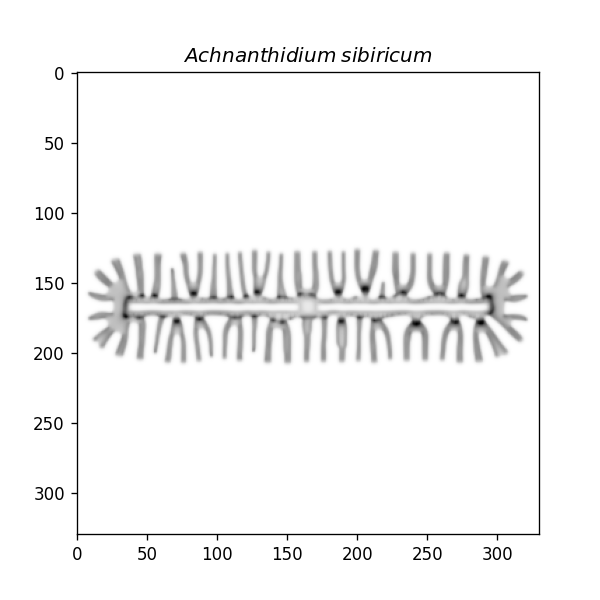

Text(0.5, 1.0, '$Achnanthidium\\;sibiricum$')

In [15]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)
ax = plt.subplot(111)

im = ax.imshow(S3,cmap='Greys')
ax.set_title(r'$Achnanthidium\;sibiricum$')

#ax.axis('off')